In [6]:
#loading packages
import os
import FeaturesData
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential
from keras.models import model_from_json
import pickle
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt


X Features : (5000, 2381, 1, 1)
Y Labels : (5000, 2)
Train size : 4000
Test Size : 1000


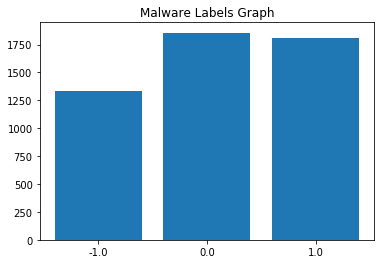

In [23]:
#reading ember dataset and then splitting into train and test
data_dir = "data1/ember2018/"
X, Y = FeaturesData.read_vectorized_features(data_dir,"train")
X = X[0:5000]
Y = Y[0:5000]
labels,count = np.unique(Y, return_counts=True)
Y = to_categorical(Y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state = 0)
print("X Features : "+str(X.shape))
print("Y Labels : "+str(Y.shape))
print("Train size : "+str(X_train.shape[0]))
print("Test Size : "+str(X_test.shape[0]))
y_pos = np.arange(len(labels))
plt.bar(y_pos, count)
plt.xticks(y_pos,labels)
plt.title("Malware Labels Graph")
plt.show()    


In [10]:
#building CNN model and then if model exists then load it else create model from scratch
if os.path.exists('model/model.json'):
    #loading CNN model
    with open('model/model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        classifier = model_from_json(loaded_model_json)
    classifier.load_weights("model/model_weights.h5")
    classifier._make_predict_function()   
    print(classifier.summary())
    f = open('model/history.pckl', 'rb')
    data = pickle.load(f)
    f.close()
    acc = data['accuracy']
    accuracy = acc[9] * 100
    print("Training Model Accuracy = "+str(accuracy))
else:
    #creating and compiling and training CNN model on ember data
    classifier = Sequential()
    classifier.add(Convolution2D(32, 1, 1, input_shape = (X.shape[1], 1, 1), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (1, 1)))
    classifier.add(Convolution2D(32, 1, 1, activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (1, 1)))
    classifier.add(Flatten())
    classifier.add(Dense(output_dim = 256, activation = 'relu'))
    classifier.add(Dense(output_dim = Y.shape[1], activation = 'softmax'))
    print(classifier.summary())
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    hist = classifier.fit(X, Y, batch_size=16, epochs=10, shuffle=True, verbose=2)
    classifier.save_weights('model/model_weights.h5')            
    model_json = classifier.to_json()
    with open("model/model.json", "w") as json_file:
        json_file.write(model_json)
    f = open('model/history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
predict = classifier.predict(X_test)
predict = np.argmax(predict, axis=1)
y_temp = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_temp,predict)*100  
print("CNN Accuracy on test data : "+str(accuracy))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2381, 1, 32)       64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2381, 1, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2381, 1, 32)       1056      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2381, 1, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 76192)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               19505408  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

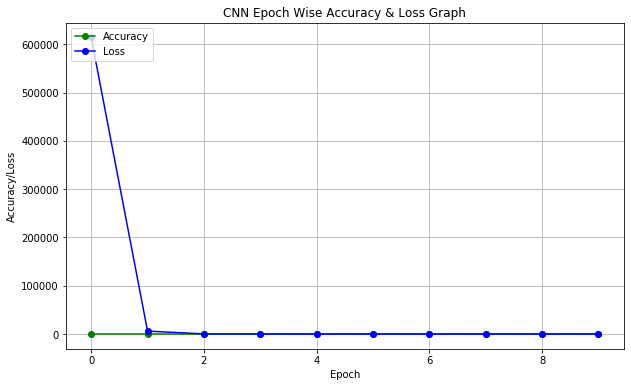

In [11]:
#CNN LOSS and accuracy graph
f = open('model/history.pckl', 'rb')
data = pickle.load(f)
f.close()
acc = data['accuracy']
loss = data['loss']
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.plot(acc, 'ro-', color = 'green')
plt.plot(loss, 'ro-', color = 'blue')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
#plt.xticks(wordloss.index)
plt.title('CNN Epoch Wise Accuracy & Loss Graph')
plt.show()


Random Forest Model Accuracy : 60.8
Decision Tree Model Accuracy : 60.8


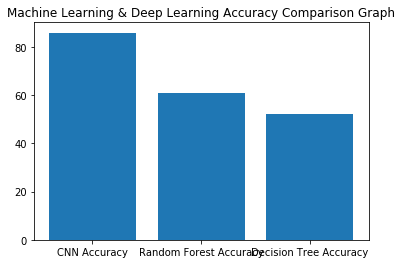

In [13]:
#training machine learning algorithms using ember malware dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#loading dataset
data_dir = "C:/acc/EagerClient/data1/ember2018/"
XX, YY = FeaturesData.read_vectorized_features(data_dir,"train")
XX = XX[0:5000]
YY = YY[0:5000]
#splitting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(XX, YY, test_size=0.2,random_state = 0)
rfc = RandomForestClassifier(random_state=42)
#training random forest classifier
rfc.fit(X_train,y_train)
predict = rfc.predict(X_test) 
random_forest_acc = accuracy_score(y_test,predict)*100
print("Random Forest Model Accuracy : "+str(random_forest_acc))

dt = DecisionTreeClassifier(random_state=42)
#training decision tree classifier
dt.fit(X_train, y_train)
#prediction on test data and then calculating accuracy
predict = dt.predict(X_test) 
decision_tree_acc = accuracy_score(y_test,predict)*100
print("Decision Tree Model Accuracy : "+str(random_forest_acc))

height = [accuracy,random_forest_acc,decision_tree_acc]
bars = ('CNN Accuracy','Random Forest Accuracy','Decision Tree Accuracy')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.title("Machine Learning & Deep Learning Accuracy Comparison Graph")
plt.show()


In [20]:
#Malware Prediction Code with normal file
from features import PEFeatureExtractor
testFile = 'antialias.exe'
file_data = open(testFile, "rb").read()
extractor = PEFeatureExtractor(2)
features = np.array(extractor.feature_vector(file_data), dtype=np.float32)
test = []
test.append(features)
test = np.asarray(test)
test = np.reshape(test, (test.shape[0], test.shape[1], 1, 1))
predict = classifier.predict(test)
predict = np.argmax(predict)
if predict == 0:
    print("\nGiven "+testFile+" is NORMAL file\n")
else:
    print("\nGiven "+testFile+" is MALWARE file\n")

Given antialias.exe is NORMAL file


In [21]:
#Malware Prediction Code with virus file
from features import PEFeatureExtractor
testFile = 'VirusShare_13c63e0329202076f45796dba3ed6b8f.exe'
file_data = open(testFile, "rb").read()
extractor = PEFeatureExtractor(2)
features = np.array(extractor.feature_vector(file_data), dtype=np.float32)
test = []
test.append(features)
test = np.asarray(test)
test = np.reshape(test, (test.shape[0], test.shape[1], 1, 1))
predict = classifier.predict(test)
predict = np.argmax(predict)
if predict == 0:
    print("\nGiven "+testFile+" is NORMAL file\n")
else:
    print("\nGiven "+testFile+" is MALWARE file\n")


Given VirusShare_13c63e0329202076f45796dba3ed6b8f.exe is MALWARE file

